## Decoding sorted by pupil size
* Search for evidence of "inverted U" in decoding effects.
    * Try normalizing to pupil max, then look at first 33%, second, third (not all datasets will have data in all categories)
    * Try splitting each recording up into thirds, so all datasets should have data in each category (but maybe not for all stim?)

In [1]:
import sys; sys.path.append("/auto/users/hellerc/code/projects/nat_pupil_ms/")
from global_settings import CPN_SITES, HIGHR_SITES
import charlieTools.nat_sounds_ms.decoding as decoding
import load_results as ld
from path_settings import DPRIME_DIR, PY_FIGURES_DIR, PY_FIGURES_DIR2, CACHE_PATH, REGRESSION

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-10-27 223132.log


In [2]:
# Define datasets
nat_data = HIGHR_SITES
cpns_data = [s for s in CPN_SITES if 'TNC' not in s]
cpnb_data = [s for s in CPN_SITES if 'TNC' in s]

In [3]:
# LOAD RAW DATA
rdata = {}
batches = [289]*len(nat_data) + [331]*len(CPN_SITES)
for site, batch in zip(nat_data+CPN_SITES, batches):
    if site in ['BOL005c', 'BOL006b']:
        b = 294
    else:
        b = batch
    X, sp_bins, X_pup, pup_mask = decoding.load_site(site=site, batch=b)
    rdata[site] = (X, sp_bins, X_pup, pup_mask)

[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/294/BOL005c_045fa3fa2325c41a82e01440f3e3128b9e8f5088.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[root INFO] Extracting cellids: ['BOL005c-04-1', 'BOL005c-06-1', 'BOL005c-07-1', 'BOL005c-09-1', 'BOL005c-09-2', 'BOL005c-10-1', 'BOL005c-12-2', 'BOL005c-13-1', 'BOL005c-13-2', 'BOL005c-18-1', 'BOL005c-19-2', 'BOL005c-22-1', 'BOL005c-24-1', 'BOL005c-25-1', 'BOL005c-25-2', 'BOL005c-25-3', 'BOL005c-27-1', 'BOL005c-29-1', 'BOL005c-32-1', 'BOL005c-33-1', 'BOL005c-34-1', 'BOL005c-37-1', 'BOL005c-37-2', 'BOL005c-43-1', 'BOL005c-44-1', 'BOL005c-44-2', 'BOL005c-46-1', 'BOL005c-47-1', 'BOL005c-48-1', 'BOL005c-48-4', 'BOL005c-49-1', 'BOL005c-49-2']
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/294/BOL006b_bce875043fd2da16341a6ac51501a985b5ad967e.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[root INFO] Extracting cellids: ['BOL006b-02-1', 'BOL006b-07-1'

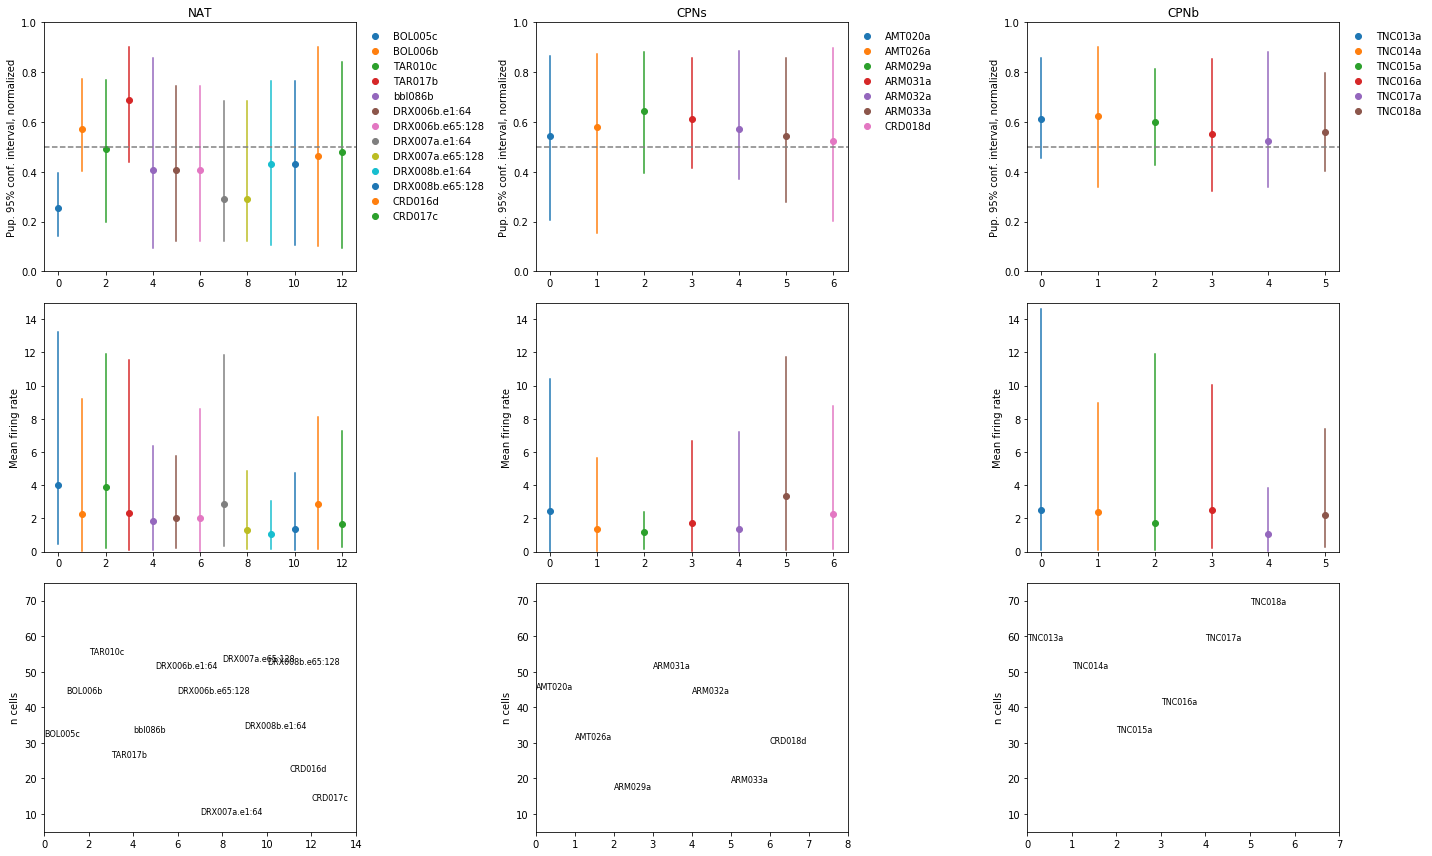

In [4]:
# COMPARE PUPIL VARIANCE, MEAN FIRING RATES, NUMBER OF CELLS
f, ax = plt.subplots(3, 3, figsize=(20, 12))

for i, (sites, dataset) in enumerate(zip([nat_data, cpns_data, cpnb_data], ['NAT', 'CPNs', 'CPNb'])):
    for j, s in enumerate(sites):
        # pupil
        p = rdata[s][2][:, :, :, ~rdata[s][1][0, 0, 0, :]].squeeze() # X_pup, keep evoked data
        p /= p.max()
        ax[0, i].plot(j, p.mean(), 'o', label=s)
        ax[0, i].plot([j, j], [np.quantile(p, 0.025), np.quantile(p, 0.975)], color=ax[0, i].get_lines()[-1].get_color())
        # firing rate
        r = rdata[s][0][:, :, :, ~rdata[s][1][0, 0, 0, :]].squeeze()
        ur = r.mean(axis=(1,2,3))
        ax[1, i].plot(j, ur.mean(), 'o', label=s)
        ax[1, i].plot([j, j], [np.quantile(ur, 0.025), np.quantile(ur, 0.975)], color=ax[1, i].get_lines()[-1].get_color())

        #ax[2, i].plot(j, len(ur), 'o')
        ax[2, i].text(j, len(ur), s, fontsize=8)
    
    ax[0, i].legend(bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
    ax[0, i].set_ylim((0, 1))
    ax[0, i].axhline(0.5, linestyle='--', color='grey')
    ax[0, i].set_title(dataset)
    ax[0, i].set_ylabel("Pup. 95% conf. interval, normalized")

    ax[1, i].set_ylabel("Mean firing rate")
    ax[1, i].set_ylim((0, 15))
    
    ax[2, i].set_ylabel("n cells")
    ax[2, i].set_ylim((5, 75))
    ax[2, i].set_xlim((0, len(sites)+1))

f.tight_layout()

### First, confirm that the decoding procedure "worked"
* We want decoding space to be the same in all cases, so there's no bias from differences there
* and should be the same space used by the big/small comparison

In [22]:
loader = decoding.DecodingResults()
m = 'dprime_jk10_zscore_fixtdr2-fa'
m1 = 'dprime_jk10_zscore_png13_fixtdr2-fa'
m2 = 'dprime_jk10_zscore_png23_fixtdr2-fa'
m3 = 'dprime_jk10_zscore_png33_fixtdr2-fa'
site = "AMT020a"
site = "ARM033a"
batch = 331

r = loader.load_results(os.path.join(DPRIME_DIR, str(batch), site, m+'_TDR.pickle'))
r1 = loader.load_results(os.path.join(DPRIME_DIR, str(batch), site, m1+'_TDR.pickle'))
r2 = loader.load_results(os.path.join(DPRIME_DIR, str(batch), site, m2+'_TDR.pickle'))
r3 = loader.load_results(os.path.join(DPRIME_DIR, str(batch), site, m3+'_TDR.pickle'))


[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM033a/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM033a/dprime_jk10_zscore_png13_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM033a/dprime_jk10_zscore_png23_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM033a/dprime_jk10_zscore_png33_fixtdr2-fa_TDR.pickle


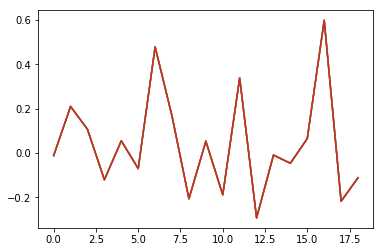

In [23]:
# decoding axis should be idenitical for each analysis
plt.figure()
for _r in [r, r1, r2, r3]:
    plt.plot(_r.array_results['wopt_all'].iloc[0]['mean'].squeeze().T)

In [26]:
r1.numeric_results['bp_dp'].isna().sum()

66

[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT020a/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT020a/dprime_jk10_zscore_png13_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT020a/dprime_jk10_zscore_png23_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT020a/dprime_jk10_zscore_png33_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT026a/dprime_jk10_zscore_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT026a/dprime_jk10_zscore_png13_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT026a/dprime_jk10_zscore_png23_fixtdr2-fa_TDR.pick

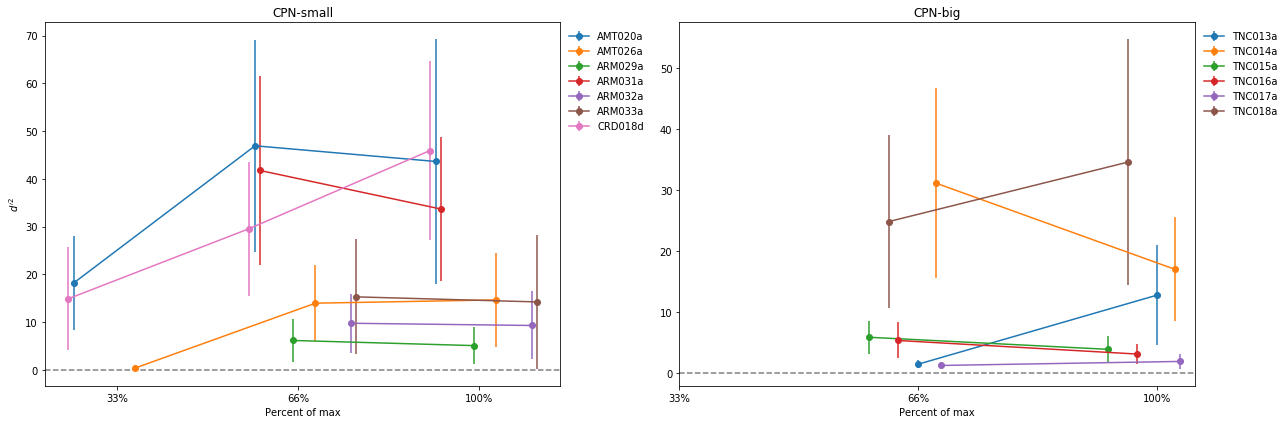

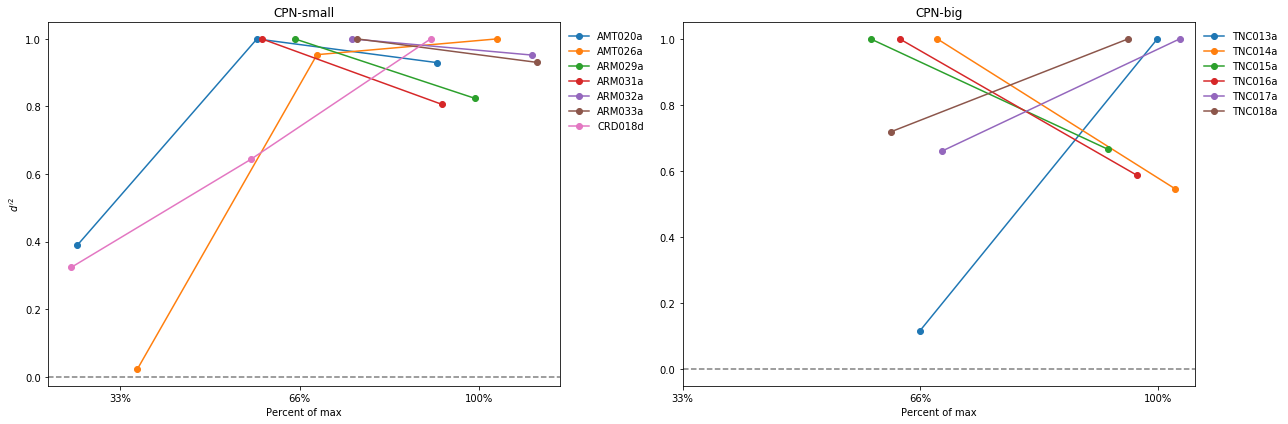

In [44]:
# DECODING EFFECTS PER SITE
f, ax = plt.subplots(1, 2, figsize=(18, 6))
f2, ax2 = plt.subplots(1, 2, figsize=(18, 6))

loader = decoding.DecodingResults()
m = 'dprime_jk10_zscore_fixtdr2-fa'
m1 = 'dprime_jk10_zscore_png13_fixtdr2-fa'
m2 = 'dprime_jk10_zscore_png23_fixtdr2-fa'
m3 = 'dprime_jk10_zscore_png33_fixtdr2-fa'
n_components = 2

for i, (dataset, batch, sites) in enumerate(zip(['CPN-small', 'CPN-big'], [331, 331], [cpns_data, cpnb_data])):
    for j, site in enumerate(sites):
        if site in ['BOL005c', 'BOL006b']:
            _batch = 294
        else:
            _batch = batch
        r = loader.load_results(os.path.join(DPRIME_DIR, str(batch), site, m+'_TDR.pickle')); df = r.numeric_results
        r1 = loader.load_results(os.path.join(DPRIME_DIR, str(batch), site, m1+'_TDR.pickle')); df1 = r1.numeric_results
        r2 = loader.load_results(os.path.join(DPRIME_DIR, str(batch), site, m2+'_TDR.pickle')); df2 = r2.numeric_results
        r3 = loader.load_results(os.path.join(DPRIME_DIR, str(batch), site, m3+'_TDR.pickle')); df3 = r3.numeric_results
        jitter = np.random.normal(0, 0.2, 1)
        ax[i].errorbar([0+jitter, 1+jitter, 2+jitter], [df1['bp_dp'].mean(),
                                   df2['bp_dp'].mean(),
                                   df3['bp_dp'].mean()],
                                   yerr = [df1['bp_dp'].std(),
                                            df2['bp_dp'].std(),
                                            df3['bp_dp'].std()], 
                                   marker='o', label=site)
        peak = np.nanmax([df1['bp_dp'].mean(), df2['bp_dp'].mean(), df3['bp_dp'].mean()])
        ax2[i].plot([0+jitter, 1+jitter, 2+jitter], [df1['bp_dp'].mean() / peak,
                                   df2['bp_dp'].mean() / peak,
                                   df3['bp_dp'].mean() / peak],
                                   marker='o', label=site)

    for a in [ax, ax2]:
        a[i].legend(bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
        a[i].axhline(0, linestyle='--', color='grey', zorder=-1)
        a[0].set_ylabel(r"$d'^2$")
        a[i].set_xticks([0, 1, 2])
        a[i].set_xticklabels(["33%", "66%", "100%"])
        a[i].set_xlabel("Percent of max")
        a[i].set_title(dataset)

f.tight_layout()
f2.tight_layout()

In [ ]:
# DECODING EFFECTS PER SITE
f, ax = plt.subplots(1, 2, figsize=(18, 6))

loader = decoding.DecodingResults()
m = 'dprime_jk10_zscore_fixtdr2-fa'
m1 = 'dprime_jk10_zscore_pbg13_fixtdr2-fa'
m2 = 'dprime_jk10_zscore_pbg23_fixtdr2-fa'
m3 = 'dprime_jk10_zscore_pbg33_fixtdr2-fa'
n_components = 2

for i, (dataset, batch, sites) in enumerate(zip(['CPN-small', 'CPN-big'], [331, 331], [cpns_data, cpnb_data])):
    for j, site in enumerate(sites):
        if site in ['BOL005c', 'BOL006b']:
            _batch = 294
        else:
            _batch = batch
        r = loader.load_results(os.path.join(DPRIME_DIR, str(batch), site, m+'_TDR.pickle')); df = r.numeric_results
        r1 = loader.load_results(os.path.join(DPRIME_DIR, str(batch), site, m1+'_TDR.pickle')); df1 = r1.numeric_results
        r2 = loader.load_results(os.path.join(DPRIME_DIR, str(batch), site, m2+'_TDR.pickle')); df2 = r2.numeric_results
        r3 = loader.load_results(os.path.join(DPRIME_DIR, str(batch), site, m3+'_TDR.pickle')); df3 = r3.numeric_results
        ax[i].errorbar([0, 1, 2], [df1['bp_dp'].mean(),
                                   df2['bp_dp'].mean(),
                                   df3['bp_dp'].mean()],
                                   yerr = [df1['bp_dp'].std(),
                                            df2['bp_dp'].std(),
                                            df3['bp_dp'].std()], 
                                   marker='o', label=site)

    ax[i].legend(bbox_to_anchor=(1, 1), loc='upper left', frameon=False)
    ax[i].axhline(0, linestyle='--', color='grey', zorder=-1)
    ax[0].set_ylabel(r"$d'^2$")
    ax[i].set_xticks([0, 1, 2])
    ax[i].set_xticklabels(["33%", "66%", "100%"])
    ax[i].set_xlabel("Percent of max")
    ax[i].set_title(dataset)

f.tight_layout()